In [8]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

In [36]:
from abc import ABC, abstractmethod
from logs import *
logger = logging.getLogger("MAB Application")
logger.setLevel(logging.DEBUG) # this on you need for you tests.

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

ch.setFormatter(CustomFormatter())

logger.addHandler(ch)


In [37]:
NUM_TRIALS = 2000
EPS = 0.1
BANDIT_Rewards = [1,2,3,4]


### Bandit Class

In [38]:
from abc import ABC, abstractmethod

class Bandit(ABC):

    @abstractmethod
    def __init__(self):
        pass
        

    @abstractmethod
    def __repr__(self):
        pass
    

    @abstractmethod
    def pull(self):
        pass
    

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def plot1(self):
        # Visualize the performance of each bandit
        pass

    @abstractmethod
    def plot2(self):
        pass

    @abstractmethod
    def report(self):
        # store the data in csv
        # print the average reward: using logging package
        # print average regret: using logging package
        pass

### Epsilion-Greedy Class

In [39]:
class EpsilonGreedy(Bandit):
    
    def __init__(self, p):
        self.p = p
        self.p_estimate = 0
        self.N = 0
    
    def __repr__(self):
        return 'A Bandit with {} Win Rate'.format(self.p)
    
    def pull(self):
        return np.random.randn() + self.p
    
    def update(self, x):
        self.N += 1
        self.p_estimate = (1 - 1.0/self.N) * self.p_estimate + 1.0/ self.N * x
    
    def experiment(self,bandit_probs,t,N=NUM_TRIALS):
        
        bandits = [EpsilonGreedy(p) for p in bandit_probs]
        BandSel = []
        means = np.array(bandit_probs) 
        true_best = np.argmax(means)  
        count_suboptimal = 0
        sample_points = [10,50,100,500,1000,1500,1999]
        data = np.empty(N)
        eps = 1/t

        for i in range(N):
            p = np.random.random() 
            
            if p < eps: 
                j = np.random.choice(len(bandits)) 
            else:
                j = np.argmax([b.p_estimate for b in bandits])
            
            x = bandits[j].pull() 
            bandits[j].update(x) 

            if j != true_best: 
                count_suboptimal += 1
            BandSel.append(j)
       
            data[i] = x 
            t+=1 
            eps = 1/t 
        
        global Reward
        Reward = data
        global BandsSel 
        BandsSel = BandSel
        
        cumulative_average = np.cumsum(data) / (np.arange(N) + 1)
        plt.plot(np.cumsum(data), label = "Cumulative reward", color = 'g')
        plt.title("Cummulative Reward")
        plt.xlabel("Num")
        plt.ylabel("Reward")
        plt.legend()
        plt.show()
        
        df = pd.DataFrame()
        df["Bandit"] = [b for b in bandits]
        df["Reward"] = [b.p_estimate for b in bandits]
        df["Algorithm"] = "EpsilonGreedy"
        
        global Greedy
        Greedy = df

        for b in bandits:
            print("Estimated average reward where epsilon for {0} = {1} : {2},\n number of times pulled {3}".format(b,eps,b.p_estimate, b.N))
        print("\n")
        print("Percent suboptimal where epsilon = {0} : {1}".format( eps, float(count_suboptimal) / N))
        print("\n")
        print(f'Cummulative average: {cumulative_average}')
        return

    def report(self, bandit_probs, N=NUM_TRIALS):
        
        bandits = [EpsilonGreedy(p) for p in bandit_probs]
        sum_= []
        for i in BandsSel:
            sum_.append(bandits[i].p)
            
        true_best = max(bandit_probs)
        best_reward = np.arange(N)
        

        regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(Reward)     
        
        
        plt.plot(regret)
        return
    
    def plot1(self):
        pass
     
    def plot2(self):
        #in a report and experiment part
        pass


### Thompson Sampling

In [40]:
class ThompsonSampling(Bandit):
    
    def __init__(self, true_mean):
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
        
    def __repr__(self):
        return 'A Bandit with {} Win Rate'.format(self.true_mean)

    def pull(self):
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean

    def sample(self):
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        self.m = (self.tau * x + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
    

    def experiment(self, bandit_rewards, NUM_TRIALS):
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        bands_selected =[]
        sample_points = [10,50,100,500,1000,1500,1999]
        rewards = np.empty(NUM_TRIALS)
        for i in range(NUM_TRIALS):
            j = np.argmax([b.sample() for b in bandits]) 

            if i in sample_points:
                self.plot1(bandits, i)

            x = bandits[j].pull()

            bandits[j].update(x)

            rewards[i] = x
            
            bands_selected.append(j)

        cumulative_average = np.cumsum(rewards) / (np.arange(NUM_TRIALS) + 1)
        
        df = pd.DataFrame()
        for b in bandits:
            print("Estimated average reward {0}  {1},\n number of times pulled {2}".format(b,b.m, b.N))
    
        print("\n")
    
        print(f'Cummulative average: {cumulative_average}')
        
        df = pd.DataFrame()
        df["Bandit"] = [b for b in bandits]
        df["Reward"] = [b.m for b in bandits]
        df["Algorithm"] = "ThompsonSampling"
        
        global REward
        REward = rewards
        global Bands_sel
        Bands_sel = bands_selected
        global Thompson
        Thompson = df
        

        plt.plot(np.cumsum(rewards), label = "Cumulative reward")
        plt.legend()
        plt.show()
        
        return cumulative_average
    
    def plot1(self,bandits, trial):
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label = f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
            plt.title("Bandit distributions after {} trials".format(trial))
        plt.legend()
        plt.show()
        pass
        
    def report(self, bandit_rewards, N = NUM_TRIALS):
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        sum_= []
        for i in Bands_sel:
            sum_.append(bandits[i].true_mean)
        
        
        true_best = max(bandit_rewards)
        best_reward = np.arange(N)
        
       
        
        regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(REward)
        
        plt.plot(regret, label = "Regret")
        return
    
    def plot2(self):
        pass


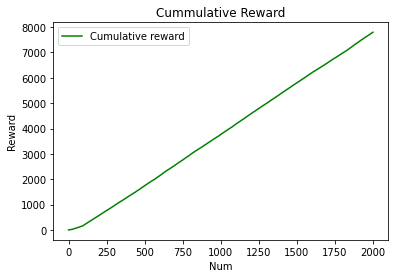

Estimated average reward where epsilon for A Bandit with 1 Win Rate = 0.0004878048780487805 : 1.1519559999913125,
 number of times pulled 36
Estimated average reward where epsilon for A Bandit with 2 Win Rate = 0.0004878048780487805 : 1.9582407390314047,
 number of times pulled 60
Estimated average reward where epsilon for A Bandit with 3 Win Rate = 0.0004878048780487805 : 0,
 number of times pulled 0
Estimated average reward where epsilon for A Bandit with 4 Win Rate = 0.0004878048780487805 : 4.011826842512027,
 number of times pulled 1904


Percent suboptimal where epsilon = 0.0004878048780487805 : 0.048


Cummulative average: [2.40457179 1.55445785 0.69539956 ... 3.89793831 3.89859422 3.89874158]


In [41]:
EpsilonGreedy(Bandit).experiment(BANDIT_Rewards, 50)

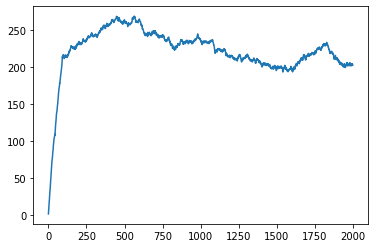

In [42]:
EpsilonGreedy(Bandit).report(BANDIT_Rewards)

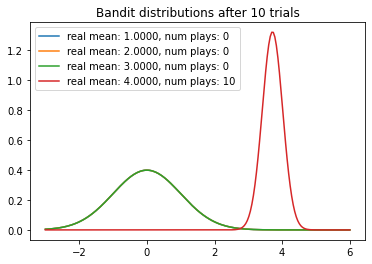

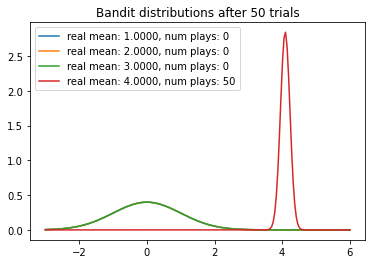

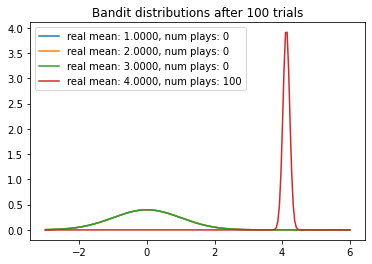

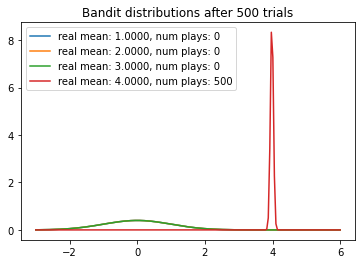

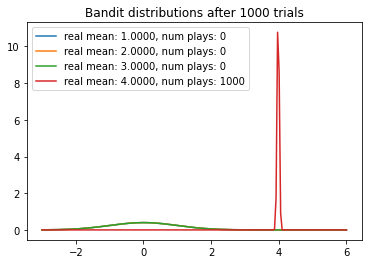

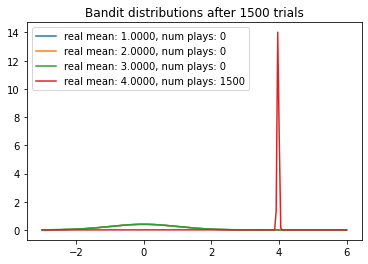

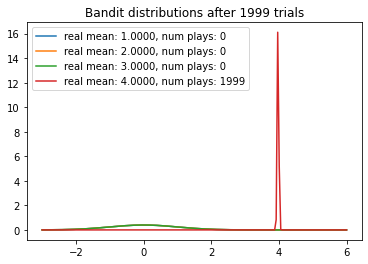

Estimated average reward A Bandit with 1 Win Rate  0,
 number of times pulled 0
Estimated average reward A Bandit with 2 Win Rate  0,
 number of times pulled 0
Estimated average reward A Bandit with 3 Win Rate  0,
 number of times pulled 0
Estimated average reward A Bandit with 4 Win Rate  3.9755361126899866,
 number of times pulled 2000


Cummulative average: [3.7280143  3.44222135 4.04705207 ... 3.97659505 3.97690311 3.97752388]


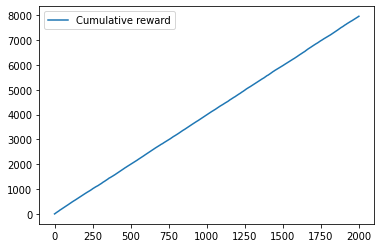

array([3.7280143 , 3.44222135, 4.04705207, ..., 3.97659505, 3.97690311,
       3.97752388])

In [43]:
ThompsonSampling(Bandit).experiment(BANDIT_Rewards, NUM_TRIALS)

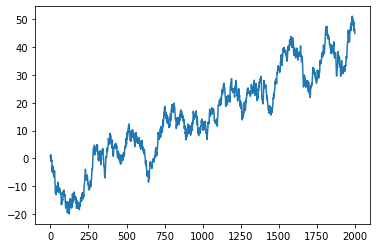

In [44]:
ThompsonSampling(Bandit).report(BANDIT_Rewards)

In [45]:
eGreedy = pd.DataFrame({"Bandit" : BandsSel, "Reward" : Reward, "Algorithm" : "Epsilon Greedy"})
eGreedy.to_csv('EpsilionGreedy.csv')
SThompson = pd.DataFrame({"Bandit" : Bands_sel, "Reward" : REward, "Algorithm" : "Thompson Sampling"})
SThompson.to_csv('ThomsponSampling.csv')

In [46]:
Greedy.to_csv("Greedy.csv")
Thompson.to_csv("Thompson.csv")